In [1]:
from googlefinance.client import get_price_data, get_prices_data
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import statsmodels.regression.linear_model as rg
import arch.unitroot as at
%matplotlib inline
stock1 = 'KAL'
stock2 = 'ASIANA'
code1 = "003490"
code2 = "020560"

C:\Users\trimu\Miniconda3\envs\py35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
start = pd.to_datetime('2017-01-01')
end =  pd.to_datetime('2018-01-01')
pair = pd.DataFrame(columns=[stock1, stock2])
pair[stock1] = pd.DataFrame(
        get_price_data({'q': code1, 'i': "86400", 'x': "KRX", 'p': "10Y" }))['Close'].loc[start : end]
pair[stock2] =pd.DataFrame(
        get_price_data({'q': code2, 'i': "86400", 'x': "KRX", 'p': "10Y" }))['Close'].loc[start : end]

pair.index = pd.to_datetime(pair.index.date)

pair[stock1 + '_return'] = pair[stock1].pct_change()
pair[stock2 + '_return'] = pair[stock2].pct_change()

In [3]:
pair[stock1 + '_log'] = np.log(pair[stock1])
pair[stock2 + '_log'] = np.log(pair[stock2])
pair.head()

,KAL,ASIANA,KAL_return,ASIANA_return,KAL_log,ASIANA_log
2017-01-02,26750.0,4175.0,NaN,NaN,10.194290,8.336870
2017-01-03,27100.0,4205.0,0.013084,0.007186,10.207289,8.344030
2017-01-04,27050.0,4205.0,-0.001845,0.000000,10.205442,8.344030
2017-01-05,27400.0,4275.0,0.012939,0.016647,10.218298,8.360539
2017-01-06,26800.0,4275.0,-0.021898,0.000000,10.196157,8.360539


In [4]:
pair[stock1 + '_cumret'] = (1 + pair[stock1 + '_return']).cumprod()
pair[stock2 + '_cumret'] = (1 + pair[stock2 + '_return']).cumprod()
pair.dropna(inplace=True)

두 주식의 price 차이가 크므로 cummulative return 으로 normalize 하여 비교

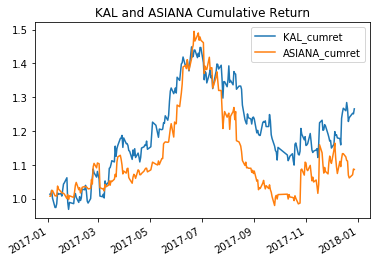

In [5]:
pair[stock1 + '_cumret'].plot(figsize=(6,4));
pair[stock2 + '_cumret'].plot()
plt.legend()
plt.title(stock1 + ' and ' + stock2 + ' Cumulative Return');

### 두 주식의 Price 의 Correlation Test

In [6]:
np.corrcoef(pair[stock1], pair[stock2])

array([[ 1.        ,  0.85759823],
       [ 0.85759823,  1.        ]])

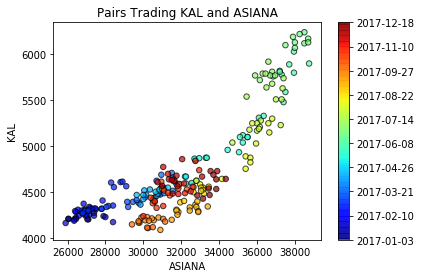

In [7]:
colors = np.linspace(0.1, 1, len(pair))
plt.figure(figsize=(6,4))

sc = plt.scatter(pair[stock1], pair[stock2], s=30, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k',
                alpha=0.7)
cb = plt.colorbar(sc)

cb.ax.set_yticklabels([str(p.date()) for p in pair[::len(pair)//9].index]);

plt.xlabel(stock2)
plt.ylabel(stock1)
plt.title('Pairs Trading ' + stock1 + ' and ' + stock2);

### stock1 을 종속변수(Y) 로 하고 stock2 를 X 로 하여 OLS regression 하여 stock1-stock2 spread 를 구함

In [8]:
model = rg.OLS(pair[stock1], pair[stock2])
result = model.fit()
beta = result.params[0]
pair['spread'] = pair[stock1] - beta * pair[stock2]
pair.head()

,KAL,ASIANA,KAL_return,ASIANA_return,KAL_log,ASIANA_log,KAL_cumret,ASIANA_cumret,spread
2017-01-03,27100.0,4205.0,0.013084,0.007186,10.207289,8.344030,1.013084,1.007186,-1396.602678
2017-01-04,27050.0,4205.0,-0.001845,0.000000,10.205442,8.344030,1.011215,1.007186,-1446.602678
2017-01-05,27400.0,4275.0,0.012939,0.016647,10.218298,8.360539,1.024299,1.023952,-1570.981320
2017-01-06,26800.0,4275.0,-0.021898,0.000000,10.196157,8.360539,1.001869,1.023952,-2170.981320
2017-01-09,26050.0,4210.0,-0.027985,-0.015205,10.167773,8.345218,0.973832,1.008383,-2480.486867


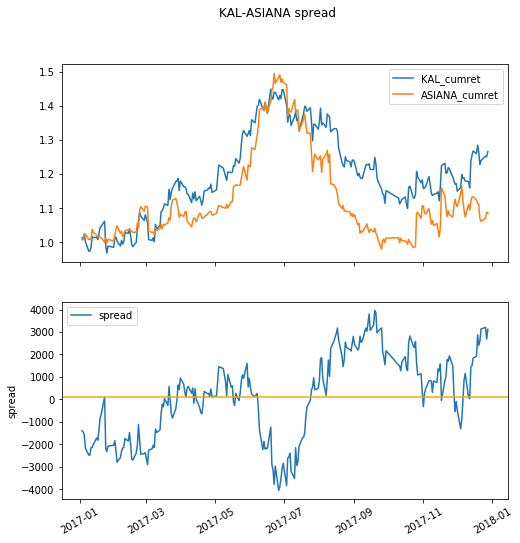

In [9]:
fig2, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))

ax1.plot(pair[stock1 + '_cumret'])
ax1.plot(pair[stock2 + '_cumret'])
ax1.legend()

ax2.plot(pair['spread'])
ax2.axhline(pair['spread'].mean(), color='orange')
ax2.legend(loc='upper left')

plt.suptitle(stock1 + '-' + stock2 + ' spread')
plt.ylabel('spread')
plt.xticks(rotation=30);

### stock1 과 stock2 가 pairs trading 의 조건을 만족하는지 TEST

1. stock1-stock2 price(cum return) 가 stationary 인지 test
2. stock1-stock2 spread 가 stationary 인지 test
    * Augment Dickey-Fuller Co-integration test
    * Phillips-Perron Co-integration test (double check)

In [10]:
at.ADF(pair[stock1 + '_return'])

Test Statistic,-12.641
P-value,0.000
Lags,1


In [11]:
at.ADF(pair[stock2 + '_return'])

Test Statistic,-2.245
P-value,0.190
Lags,15


### stock1 과 stock2 의 daily return 은 stationary 이다.

In [12]:
at.ADF(pair['spread'])

Test Statistic,-1.885
P-value,0.339
Lags,4


In [13]:
at.PhillipsPerron(pair['spread'])   # double check

Test Statistic,-1.973
P-value,0.299
Lags,15


### 두가지 test 의 p-value < 0.05 이므로 stock1-stock2 의 spread 가 stationary 이므로, 두 주식은 co-integration 되어 있다.

### daily return 이 stationary 하고 상호 cointegration 되어 있으므로 Pairs Trading 의 조건을 만족시킨다.

### stock1-stock2 rolling beta 계산

In [14]:
window = 63

In [15]:
rolling_cov = pair.loc[:, [stock1, stock2]].rolling(window)\
                    .cov(pair.loc[:, [stock1, stock2]], pairwise=True)

In [16]:
idx = pd.IndexSlice
rolling_cov = rolling_cov.loc[idx[:, stock1], stock2].reset_index(level=1)

In [17]:
rolling_var = pair[stock2].rolling(window).var()

In [18]:
pair['rolling_beta'] = rolling_cov[stock2] / rolling_var

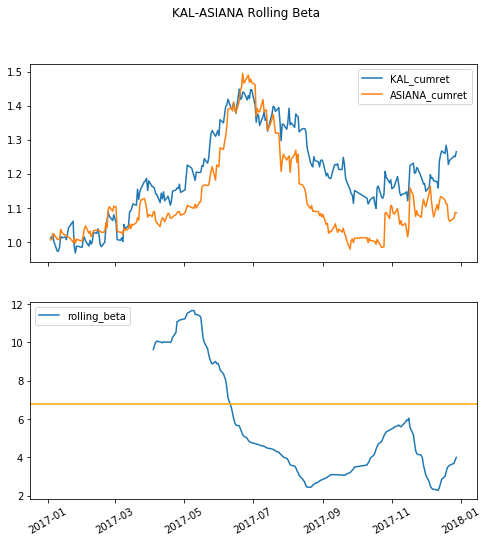

In [19]:
fig3, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))

ax1.plot(pair[stock1 + '_cumret'])
ax1.plot(pair[stock2 + '_cumret'])
ax1.legend()

ax2.plot(pair['rolling_beta'])
ax2.axhline(beta, color='orange')
ax2.legend(loc="upper left")
plt.suptitle(stock1 + '-' + stock2 + ' Rolling Beta')
plt.xticks(rotation=30);

In [20]:
pair['rolling_spread'] = pair[stock1] - pair['rolling_beta'] * pair[stock2]
rolling_mean = pair['rolling_spread'].rolling(window).mean()
rolling_std = pair['rolling_spread'].rolling(window).std()

In [21]:
pair.head()

,KAL,ASIANA,KAL_return,ASIANA_return,KAL_log,ASIANA_log,KAL_cumret,ASIANA_cumret,spread,rolling_beta,rolling_spread
2017-01-03,27100.0,4205.0,0.013084,0.007186,10.207289,8.344030,1.013084,1.007186,-1396.602678,NaN,NaN
2017-01-04,27050.0,4205.0,-0.001845,0.000000,10.205442,8.344030,1.011215,1.007186,-1446.602678,NaN,NaN
2017-01-05,27400.0,4275.0,0.012939,0.016647,10.218298,8.360539,1.024299,1.023952,-1570.981320,NaN,NaN
2017-01-06,26800.0,4275.0,-0.021898,0.000000,10.196157,8.360539,1.001869,1.023952,-2170.981320,NaN,NaN
2017-01-09,26050.0,4210.0,-0.027985,-0.015205,10.167773,8.345218,0.973832,1.008383,-2480.486867,NaN,NaN


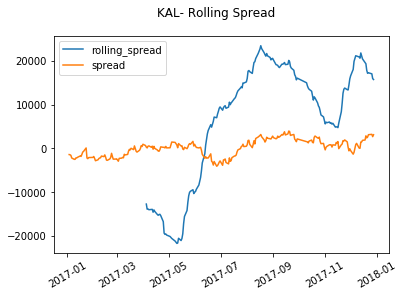

In [22]:
#fig4, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6))
fig4, ax3 = plt.subplots()

#ax1.plot(pair[stock1 + '_cumret'])
#ax1.plot(pair[stock2 + '_cumret'])
#ax1.legend()

#ax2.plot(pair['rolling_beta'])
#ax2.axhline(beta, color='orange')
#ax2.legend(loc="upper left")

ax3.plot(pair['rolling_spread'])
#ax3.plot(rolling_mean, label='rolling_mean')
#ax3.plot(rolling_std, label='rolling_std')
ax3.plot(pair['spread'])
ax3.legend(loc="upper left")
plt.suptitle(stock1 + '-' + ' Rolling Spread')
plt.xticks(rotation=30);

### stock1-stock2 Rolling Spread Z-Score calculation and Chart

In [23]:
pair['rolling_zscore'] = (pair['rolling_spread'] - rolling_mean) / rolling_std

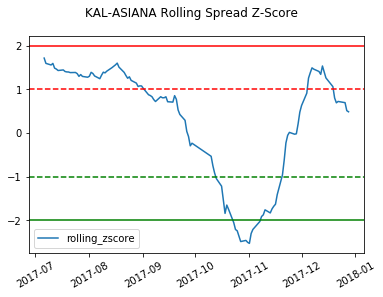

In [24]:
fig5, ax = plt.subplots()
ax.plot(pair['rolling_zscore'])
ax.axhline((-2), color='green')
ax.axhline((-1), color='green', linestyle='--')
ax.axhline((+2), color='red')
ax.axhline((+1), color='red', linestyle='--')
ax.legend(loc="lower left")
plt.xticks(rotation=30)
plt.suptitle(stock1 + '-' + stock2 + ' Rolling Spread Z-Score');

### Trading Signal  and chart

In [25]:
pair['rolling_zscore(-1)'] = pair['rolling_zscore'].shift(1)  # current zscore
pair['rolling_zscore(-2)'] = pair['rolling_zscore'].shift(2)  # previous zscore
pair['signal'] = 0
signal = 0
for i, r in enumerate(pair.iterrows()):
    if r[1]['rolling_zscore(-2)'] > -2 and r[1]['rolling_zscore(-1)'] < -2:    # Enter Long
        signal = -2
    elif r[1]['rolling_zscore(-2)'] < -1 and r[1]['rolling_zscore(-1)'] > -1:  # Exit Long
        signal = -1
    elif r[1]['rolling_zscore(-2)'] < 2 and r[1]['rolling_zscore(-1)'] > 2:     # Enter Short
        signal = 2
    elif r[1]['rolling_zscore(-2)'] > 1 and r[1]['rolling_zscore(-1)'] < 1:      # Exit Short
        signal = 1
    else:
        signal = 0
    pair.iloc[i, pair.columns.get_loc('signal')] = signal

In [26]:
pair['position'] = 0
position = 0
for i, r in enumerate(pair.iterrows()):
    if r[1]['signal'] == -2:
        position = 1
    elif r[1]['signal'] == 2:
        position = -1
    elif r[1]['signal'] == -1 or  r[1]['signal'] == 1:
        position = 0
    else:
        position = pair.loc[:, 'position'][i - 1]
    pair.iloc[i, pair.columns.get_loc('position')] = position

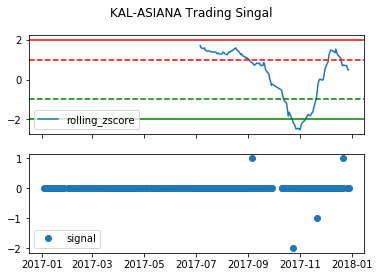

In [27]:
#fig6, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig6, (ax1, ax2) = plt.subplots(2, sharex=True)  

ax1.plot(pair['rolling_zscore'])
ax1.axhline((-2), color='green')
ax1.axhline((-1), color='green', linestyle='--')
ax1.axhline((+2), color='red')
ax1.axhline((+1), color='red', linestyle='--')
ax1.legend(loc="lower left")

ax2.plot(pair['signal'], marker='o', linestyle='')
ax2.legend(loc='lower left')

#ax3.plot(pair['position'], marker='o', linestyle='')
#plt.xticks(rotation=30)
#ax3.legend(loc='lower left')
plt.suptitle(stock1 + '-' + stock2 + ' Trading Singal');

In [28]:
pair['spread_return'] = pair[stock1 + '_return'] - pair['rolling_beta'] * pair[stock2 + '_return']
pair['return'] = pair['spread_return'] * pair['position']

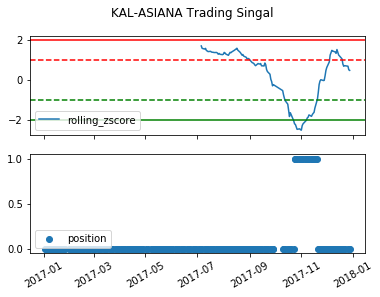

In [29]:
#fig6, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig6, (ax1, ax2) = plt.subplots(2, sharex=True)  

ax1.plot(pair['rolling_zscore'])
ax1.axhline((-2), color='green')
ax1.axhline((-1), color='green', linestyle='--')
ax1.axhline((+2), color='red')
ax1.axhline((+1), color='red', linestyle='--')
ax1.legend(loc="lower left")

ax2.plot(pair['position'], marker='o', linestyle='')
plt.xticks(rotation=30)
ax2.legend(loc='lower left')
plt.suptitle(stock1 + '-' + stock2 + ' Trading Singal');

In [30]:
pair['position(-1)'] = pair['position'].shift(1)
pair['commission'] = 0

In [31]:
for i, r in enumerate(pair.iterrows()):
    if (r[1]['signal'] == -2 or r[1]['signal'] == -1 or r[1]['signal'] == 2 or r[1]['signal'] == 1 ) and \
        r[1]['position'] != r[1]['position(-1)']:
        commission = 0
    else:
        commission = 0
    pair.iloc[i, pair.columns.get_loc('commission')] = commission

pair['return_c'] = pair['return'] - pair['commission']

## Performance Backtest

Cummulative Annualized Return and Chart

In [33]:
pair[np.isnan(pair)] = 0
pair['ann_return'] = np.cumprod(pair['return_c'] + 1) ** (252/len(pair)) - 1
pair['ann_' + stock1] = np.cumprod(pair[stock1 + '_return'] + 1) ** (252/len(pair)) - 1
pair['ann_' + stock2] = np.cumprod(pair[stock2 + '_return'] + 1) ** (252/len(pair)) - 1

In [34]:
pair.tail()

,KAL,ASIANA,KAL_return,ASIANA_return,KAL_log,ASIANA_log,KAL_cumret,ASIANA_cumret,spread,rolling_beta,...,signal,position,spread_return,return,position(-1),commission,return_c,ann_return,ann_KAL,ann_ASIANA
2017-12-21,32850.0,4465.0,-0.029542,-0.037716,10.399707,8.404024,1.228037,1.069461,2591.419510,3.526392,...,1,0,0.103458,0.0,0.0,0,0.0,-0.728333,0.238506,0.072433
2017-12-22,33150.0,4430.0,0.009132,-0.007839,10.408798,8.396155,1.239252,1.061078,3128.608831,3.594171,...,0,0,0.037306,0.0,0.0,0,0.0,-0.728333,0.250286,0.063680
2017-12-26,33500.0,4470.0,0.010558,0.009029,10.419301,8.405144,1.252336,1.070659,3207.535322,3.693034,...,0,0,-0.022788,-0.0,0.0,0,-0.0,-0.728333,0.264035,0.073684
2017-12-27,33450.0,4540.0,-0.001493,0.015660,10.417807,8.420682,1.250467,1.087425,2683.156680,3.865346,...,0,0,-0.062024,-0.0,0.0,0,-0.0,-0.728333,0.262070,0.091198
2017-12-28,33850.0,4535.0,0.011958,-0.001101,10.429694,8.419580,1.265421,1.086228,3117.040869,4.002957,...,0,0,0.016367,0.0,0.0,0,0.0,-0.728333,0.277790,0.089946


C:\Users\trimu\Miniconda3\envs\py35\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


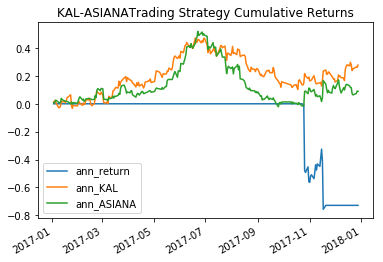

In [35]:
pair.plot(y=['ann_return', 'ann_' + stock1, 'ann_' + stock2])

plt.title(stock1 + '-' + stock2 + 'Trading Strategy Cumulative Returns');